**Librairies and data import**

In [337]:
#Import librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

import scikit_posthocs as sp

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import os
os.environ["OMP_NUM_THREADS"] = "1" 

import warnings
warnings.filterwarnings('ignore')


In [338]:
#Data import (first column is not imported, col=0)
df_daily_activity=pd.read_csv("daily_activity.csv", sep= ",", encoding="latin", index_col=0)
df_sleep_data=pd.read_csv("sleep_data.csv", sep=",", encoding= "latin", index_col=0)
df_weight_data=pd.read_csv("weight_data.csv", sep=",", encoding= "latin", index_col=0)

**Daily activity**

*Exploration*

In [341]:
#Check missing values
df_daily_activity.isna().sum()

#Transform ActivityDate
df_daily_activity['ActivityDate'] = pd.to_datetime(df_daily_activity['ActivityDate'], format='%Y-%m-%d')

*Cleaning*

In [343]:
# Cleaning data
df_daily_activity_cleaned = df_daily_activity.copy()

#Remove duplicates
df_daily_activity_cleaned = df_daily_activity_cleaned.drop_duplicates(subset=['Id', 'ActivityDate'], keep='first')

# Filters
df_daily_activity_cleaned = df_daily_activity_cleaned[df_daily_activity_cleaned['SedentaryMinutes'] < 1440]
df_daily_activity_cleaned = df_daily_activity_cleaned[df_daily_activity_cleaned['Calories'] > 0]
df_daily_activity_cleaned = df_daily_activity_cleaned[df_daily_activity_cleaned['TotalSteps'] >= 100]

# New column
df_daily_activity_cleaned['TotalMinutes'] = (
    df_daily_activity_cleaned['VeryActiveMinutes'] +
    df_daily_activity_cleaned['ModeratelyActiveMinutes'] +
    df_daily_activity_cleaned['LightlyActiveMinutes'] +
    df_daily_activity_cleaned['SedentaryMinutes']
)

# Filter on TotalMinutes
df_daily_activity_cleaned = df_daily_activity_cleaned[
    (df_daily_activity_cleaned['TotalMinutes'] >= 480) &
    (df_daily_activity_cleaned['TotalMinutes'] <= 1440)
]

df_daily_activity_cleaned['TotalActiveMinutes'] = (
    df_daily_activity_cleaned['VeryActiveMinutes'] +
    df_daily_activity_cleaned['ModeratelyActiveMinutes'] +
    df_daily_activity_cleaned['LightlyActiveMinutes']
)


#Keep only users with more 10 recordings
df_daily_activity_cleaned = df_daily_activity_cleaned[
    df_daily_activity_cleaned['Id'].isin(
        df_daily_activity_cleaned['Id'].value_counts()[lambda x: x >= 10].index
    )
]

In [344]:
df_daily_activity_cleaned.describe()

,Id,ActivityDate,TotalSteps,TotalDistanceKm,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,VeryActiveMinutes,ModeratelyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalMinutes,TotalActiveMinutes
count,9.060000e+02,906,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000
mean,4.581154e+09,2016-04-19 17:24:14.304635904,8138.257174,5.779139,1.558709,0.589492,3.590839,22.286976,14.292494,211.931567,963.759382,2342.569536,1212.270419,248.511038
min,1.503960e+09,2016-03-15 00:00:00,108.000000,0.080000,0.000000,0.000000,0.030000,0.000000,0.000000,3.000000,356.000000,706.000000,507.000000,3.000000
25%,2.026352e+09,2016-04-09 00:00:00,4516.750000,3.100000,0.000000,0.000000,2.242500,0.000000,0.000000,147.000000,728.000000,1850.000000,990.000000,177.500000
50%,4.445115e+09,2016-04-20 00:00:00,7604.500000,5.360000,0.330000,0.270000,3.470000,5.000000,8.000000,207.000000,1026.000000,2210.000000,1358.500000,255.000000
75%,6.962181e+09,2016-05-01 00:00:00,11043.000000,7.717500,2.167500,0.860000,4.797500,33.000000,21.000000,273.000000,1191.750000,2789.000000,1440.000000,321.750000
max,8.877689e+09,2016-05-12 00:00:00,36019.000000,28.030000,21.920000,6.400000,12.510000,210.000000,141.000000,586.000000,1437.000000,4900.000000,1440.000000,602.000000
std,2.459783e+09,NaN,4803.891834,3.684977,2.678178,0.838019,1.859843,33.600667,19.213298,94.259075,268.350940,694.757092,244.111769,103.542387


In [345]:
df_daily_activity_cleaned['Id'].nunique()

31

*Visualisation*

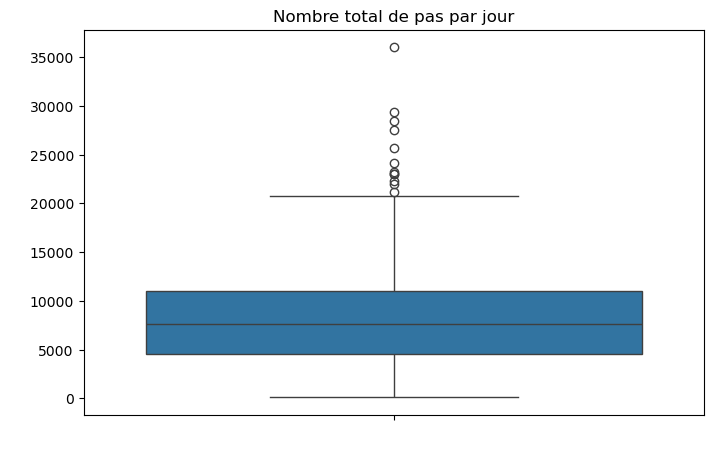

In [347]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(y="TotalSteps", data=df_daily_activity_cleaned)
ax.set_title("Nombre total de pas par jour")
ax.set_ylabel(" ")
ax.set_xlabel(" ");

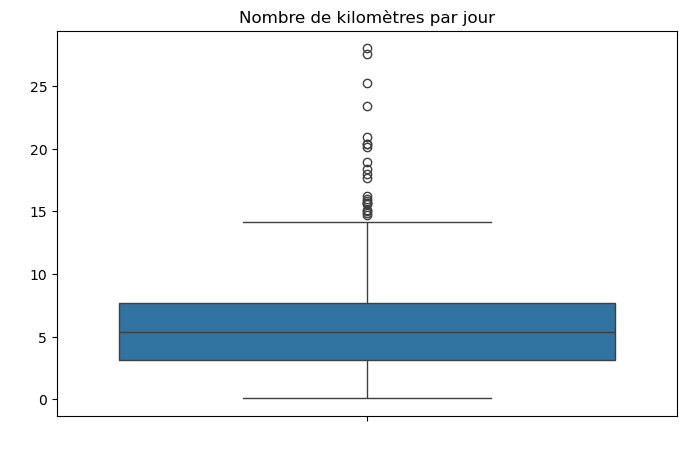

In [348]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(y="TotalDistanceKm", data=df_daily_activity_cleaned)
ax.set_title("Nombre de kilomètres par jour")
ax.set_ylabel(" ")
ax.set_xlabel(" ");

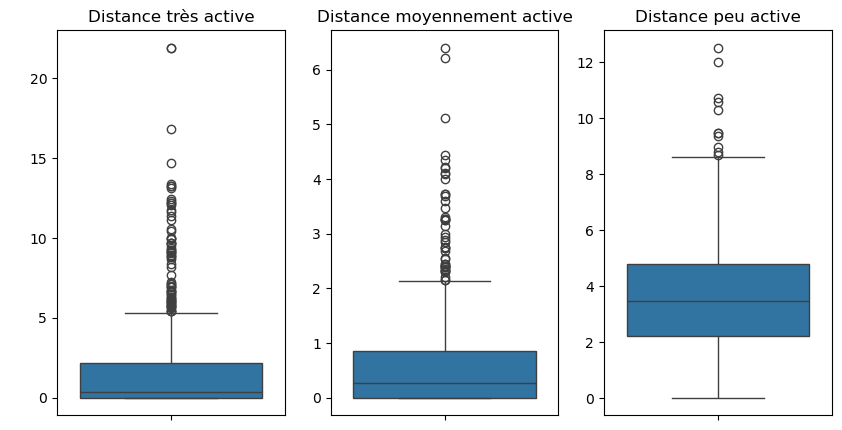

In [349]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5)) 
sns.boxplot(y="VeryActiveDistance", data=df_daily_activity_cleaned, ax=axes[0])
axes[0].set_title("Distance très active")
axes[0].set_ylabel(" ");
sns.boxplot(y="ModeratelyActiveDistance", data=df_daily_activity_cleaned, ax=axes[1])
axes[1].set_title("Distance moyennement active")
axes[1].set_ylabel(" ");
sns.boxplot(y="LightActiveDistance", data=df_daily_activity_cleaned, ax=axes[2])
axes[2].set_title("Distance peu active")
axes[2].set_ylabel(" ");

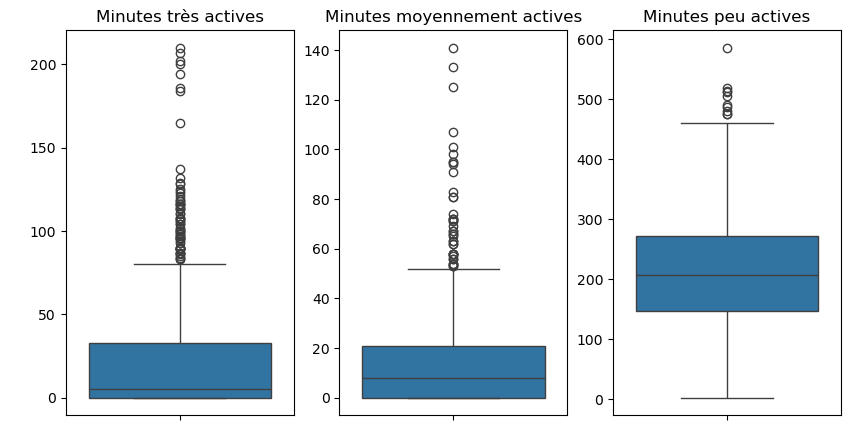

In [350]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5)) 
sns.boxplot(y="VeryActiveMinutes", data=df_daily_activity_cleaned, ax=axes[0])
axes[0].set_title("Minutes très actives")
axes[0].set_ylabel(" ");
sns.boxplot(y="ModeratelyActiveMinutes", data=df_daily_activity_cleaned, ax=axes[1])
axes[1].set_title("Minutes moyennement actives")
axes[1].set_ylabel(" ");
sns.boxplot(y="LightlyActiveMinutes", data=df_daily_activity_cleaned, ax=axes[2])
axes[2].set_title("Minutes peu actives")
axes[2].set_ylabel(" ");

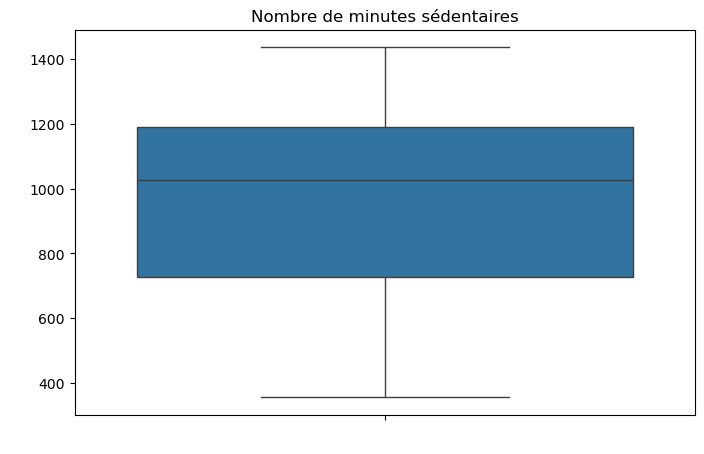

In [351]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(y="SedentaryMinutes", data=df_daily_activity_cleaned)
ax.set_title("Nombre de minutes sédentaires")
ax.set_ylabel(" ")
ax.set_xlabel(" ");

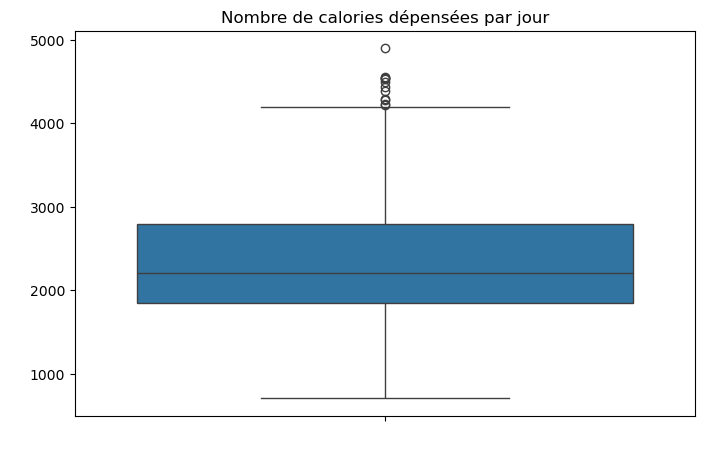

In [352]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(y="Calories", data=df_daily_activity_cleaned)
ax.set_title("Nombre de calories dépensées par jour")
ax.set_ylabel(" ")
ax.set_xlabel(" ");

**Sleep data**

*Exploration*

In [355]:
#Check missing values
df_sleep_data.isna().sum()

#Transform ActivityDate
df_sleep_data['Date'] = pd.to_datetime(df_sleep_data['Date'], format='%Y-%m-%d')

#Add column
df_sleep_data["TimeAwake"] = df_sleep_data["TotalTimeInBed"] - df_sleep_data["TotalMinutesAsleep"]

#Add column
df_sleep_data['SleepEfficiency'] = df_sleep_data['TotalMinutesAsleep'] / df_sleep_data['TotalTimeInBed']

*Cleaning*

In [357]:
# Remove duplicates
df_sleep_data_cleaned=df_sleep_data.copy()
df_sleep_data_cleaned = df_sleep_data_cleaned.drop_duplicates(subset=['Id', 'Date'], keep='first')

In [358]:
#Keep only 10 nights per user
df_sleep_data_cleaned = df_sleep_data_cleaned[
    df_sleep_data_cleaned['Id'].isin(
        df_sleep_data_cleaned['Id'].value_counts()[lambda x: x >= 10].index
    )
]

In [359]:
df_sleep_data_cleaned.shape

(376, 6)

In [360]:
df_sleep_data_cleaned['Id'].nunique()

15

In [361]:
df_sleep_data_cleaned.describe()

,Id,Date,TotalMinutesAsleep,TotalTimeInBed,TimeAwake,SleepEfficiency
count,3.760000e+02,376,376.000000,376.000000,376.000000,376.000000
mean,5.080863e+09,2016-04-26 12:57:26.808510720,428.385638,466.914894,38.529255,0.917275
min,1.503960e+09,2016-04-12 00:00:00,59.000000,65.000000,1.000000,0.498361
25%,3.977334e+09,2016-04-19 00:00:00,373.000000,413.750000,18.000000,0.913124
50%,4.702922e+09,2016-04-26 12:00:00,436.500000,467.500000,27.000000,0.943314
75%,6.962181e+09,2016-05-04 00:00:00,492.000000,527.750000,40.000000,0.960695
max,8.792010e+09,2016-05-12 00:00:00,775.000000,843.000000,243.000000,0.997763
std,2.033856e+09,NaN,100.862244,99.470455,40.986361,0.087622


*Visualisation*

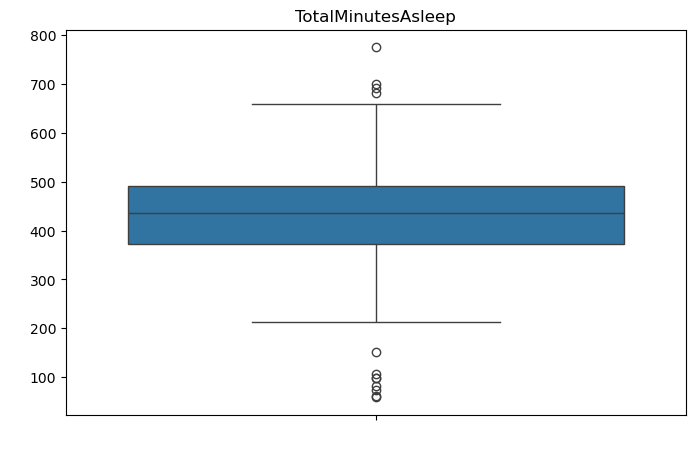

In [363]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(y="TotalMinutesAsleep", data=df_sleep_data_cleaned)
ax.set_title("TotalMinutesAsleep")
ax.set_ylabel(" ")
ax.set_xlabel(" ");

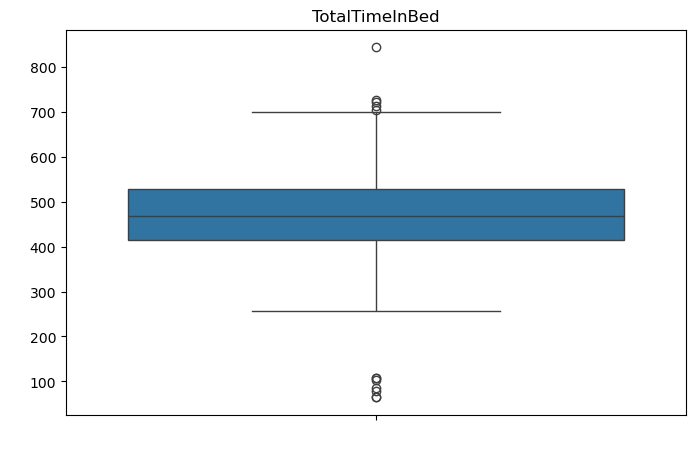

In [364]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(y="TotalTimeInBed", data=df_sleep_data_cleaned)
ax.set_title("TotalTimeInBed")
ax.set_ylabel(" ")
ax.set_xlabel(" ");

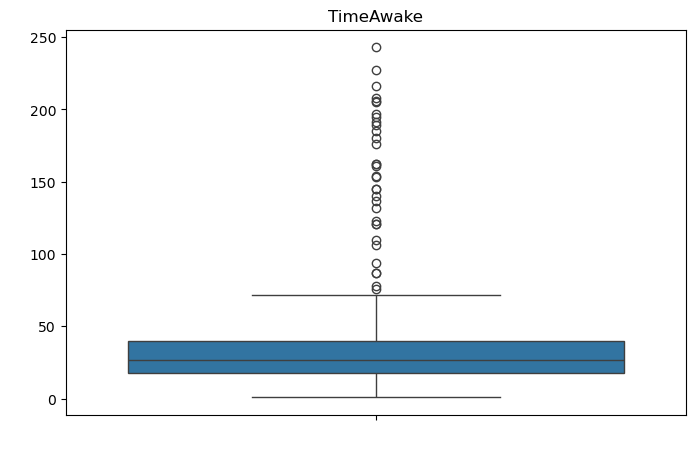

In [365]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(y="TimeAwake", data=df_sleep_data_cleaned)
ax.set_title("TimeAwake")
ax.set_ylabel(" ")
ax.set_xlabel(" ");

**BMI**

*Exploration*

In [368]:
#Check missing values
df_weight_data.isna().sum()

#Transform ActivityDate
df_weight_data['Date'] = pd.to_datetime(df_weight_data['Date'], format='%Y-%m-%d')

*Cleaning*

In [370]:
# Remove duplicates
df_weight_data_cleaned=df_weight_data.copy()
df_weight_data_cleaned = df_weight_data_cleaned.drop_duplicates(subset=['Id', 'Date'], keep='first')

In [371]:
df_weight_data_cleaned.shape

(98, 4)

In [372]:
df_weight_data_cleaned['Id'].nunique()

13

In [373]:
df_weight_data_cleaned.describe()

,Id,Date,WeightKg,BMI
count,9.800000e+01,98,98.000000,98.000000
mean,6.811512e+09,2016-04-20 03:25:42.857142784,72.466327,25.372041
min,1.503960e+09,2016-03-30 00:00:00,52.600000,21.450000
25%,6.962181e+09,2016-04-08 06:00:00,61.500000,24.000000
50%,6.962181e+09,2016-04-19 12:00:00,62.500000,24.390000
75%,8.877689e+09,2016-05-01 00:00:00,85.250000,25.590000
max,8.877689e+09,2016-05-12 00:00:00,133.500000,47.540000
std,2.089879e+09,NaN,14.820618,3.555762


**Clustering - Physical activity**

Objectives: Group users according to their physical activity profile and identify typical profiles (active, 
moderately active, sedentary)

 Approach:
 - Aggregate daily data (steps, calories, active minutes, sedentary time)
 - Apply clustering methods (K-means, hierarchical)
 - Interpret clusters according to activity level and compare with sleep or BMI

In [376]:
df_daily_activity_cleaned.shape

(906, 14)

In [377]:
df_daily_activity_cleaned['Id'].nunique()

31

In [378]:
df_daily_activity_cleaned.groupby('Id').size() \
    .reset_index(name='count') \
    .sort_values(by='count', ascending=False)

,Id,count
0,1503960366,47
1,1624580081,46
5,2022484408,41
15,4558609924,41
17,5553957443,40
6,2026352035,40
25,8053475328,40
2,1644430081,39
7,2320127002,37
14,4445114986,37


In [379]:
df_sleep_data_cleaned.shape

(376, 6)

In [380]:
df_sleep_data_cleaned['Id'].nunique()

15

In [381]:
df_sleep_data_cleaned.groupby('Id').size() \
    .reset_index(name='count') \
    .sort_values(by='count', ascending=False)

,Id,count
8,5553957443,31
11,6962181067,31
13,8378563200,31
1,2026352035,28
3,3977333714,28
6,4445114986,28
7,4702921684,27
4,4319703577,26
9,5577150313,26
0,1503960366,25


In [382]:
df_daily_activity_cleaned = df_daily_activity_cleaned.rename(columns={'ActivityDate': 'Date'})
df_sleep_data_cleaned = df_sleep_data_cleaned.rename(columns={'SleepDate': 'Date'})

*Clustering according to physical activity and level of sedentary behavior*

In [384]:
df_cluster = df_daily_activity_cleaned.copy()
df_cluster = df_cluster[['Id', 'Date', 'TotalSteps','TotalDistanceKm', 'TotalActiveMinutes', 'SedentaryMinutes', 'Calories']]
df_cluster['Date'] = pd.to_datetime(df_cluster['Date'])
df_cluster['week'] = df_cluster['Date'].dt.isocalendar().week
df_cluster['year'] = df_cluster['Date'].dt.isocalendar().year
df_cluster['weekday'] = df_cluster['Date'].dt.day_name()
df_cluster['is_weekend'] = df_cluster['Date'].dt.weekday >= 5

In [385]:
df_user_summary = df_cluster.groupby('Id').agg(
    mean_total_steps=('TotalSteps', 'mean'),
    mean_total_distance_km=('TotalDistanceKm', 'mean'),
    mean_total_active_minutes=('TotalActiveMinutes', 'mean'),
    mean_sedentary_minutes=('SedentaryMinutes', 'mean'),
    mean_calories=('Calories', 'mean')
).reset_index()

In [386]:
features = ['mean_total_active_minutes', 'mean_sedentary_minutes']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_user_summary[features])

In [387]:
df_user_summary.describe()

,Id,mean_total_steps,mean_total_distance_km,mean_total_active_minutes,mean_sedentary_minutes,mean_calories
count,3.100000e+01,31.000000,31.000000,31.000000,31.000000,31.000000
mean,4.898138e+09,8060.034356,5.740856,250.989144,965.110492,2364.891862
std,2.507528e+09,3396.942554,2.647807,69.059367,210.569472,596.163980
min,1.503960e+09,1860.333333,1.288519,89.444444,666.166667,1441.065217
25%,2.333647e+09,5490.667655,3.825395,211.043561,731.687865,1898.250000
50%,4.558610e+09,7946.358974,5.387500,245.775000,1040.666667,2321.037037
75%,6.984963e+09,9867.489662,7.061667,297.311382,1149.882692,2776.848485
max,8.877689e+09,17786.631579,14.107895,367.433333,1275.333333,3551.631579


In [388]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_user_summary['cluster'] = kmeans.fit_predict(X_scaled)

order = df_user_summary.groupby('cluster')['mean_total_active_minutes'].mean().sort_values().index
order = (
    df_user_summary
    .groupby('cluster')['mean_total_active_minutes']
    .mean()
    .sort_values()
    .index
)
mapping = {old: new for new, old in enumerate(order)}
df_user_summary['cluster_ordered'] = df_user_summary['cluster'].map(mapping)

label_mapping = {0: 'Sédentaire', 1: 'Actif', 2: 'Modéré'}
df_user_summary['cluster_label'] = df_user_summary['cluster_ordered'].map(label_mapping)

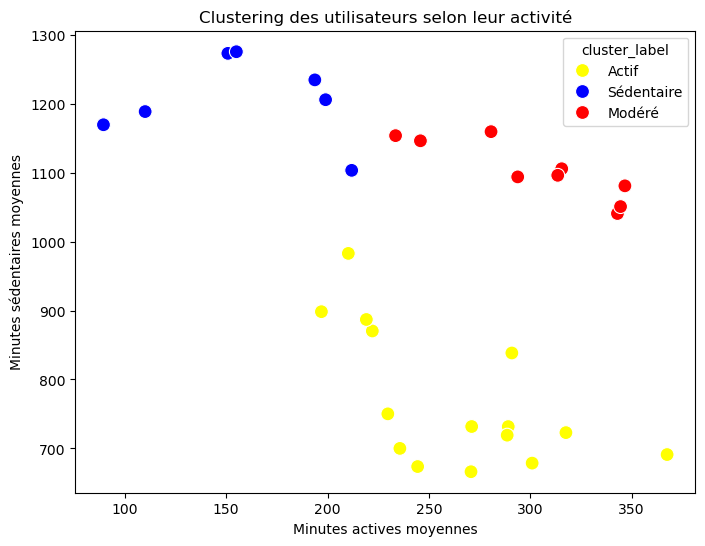

In [389]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_user_summary,
    x='mean_total_active_minutes',
    y='mean_sedentary_minutes',
    hue='cluster_label',      # <- utiliser les labels texte
    palette={'Sédentaire':'blue', 'Modéré':'red', 'Actif':'yellow'},
    s=100
)
plt.xlabel("Minutes actives moyennes")
plt.ylabel("Minutes sédentaires moyennes")
plt.title("Clustering des utilisateurs selon leur activité")
plt.show()

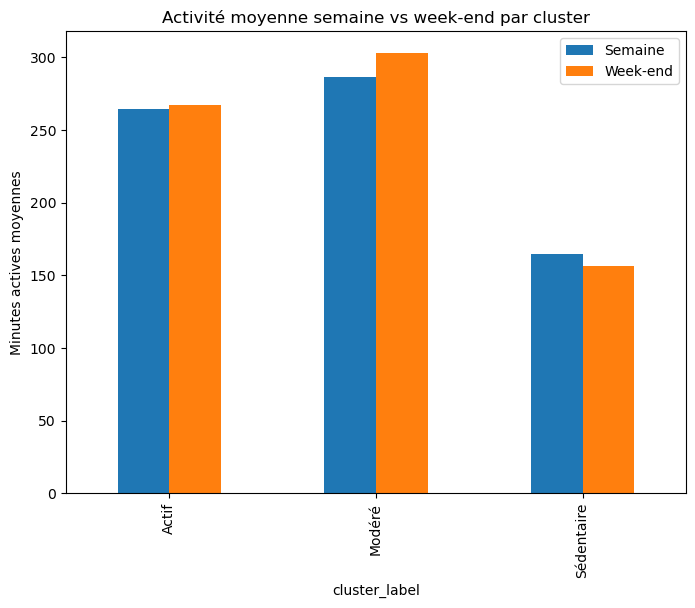

In [468]:
df_clustered = df_cluster.merge(
    df_user_summary[['Id', 'cluster_label']],
    on='Id',
    how='left'
)

activity_by_cluster_daytype = (
    df_clustered
    .groupby(['cluster_label', 'is_weekend'])['TotalActiveMinutes']
    .mean()
    .unstack()
)

activity_by_cluster_daytype.columns = ['Semaine', 'Week-end']

activity_by_cluster_daytype.plot(kind='bar', figsize=(8,6))
plt.ylabel('Minutes actives moyennes')
plt.title('Activité moyenne semaine vs week-end par cluster')
plt.show()

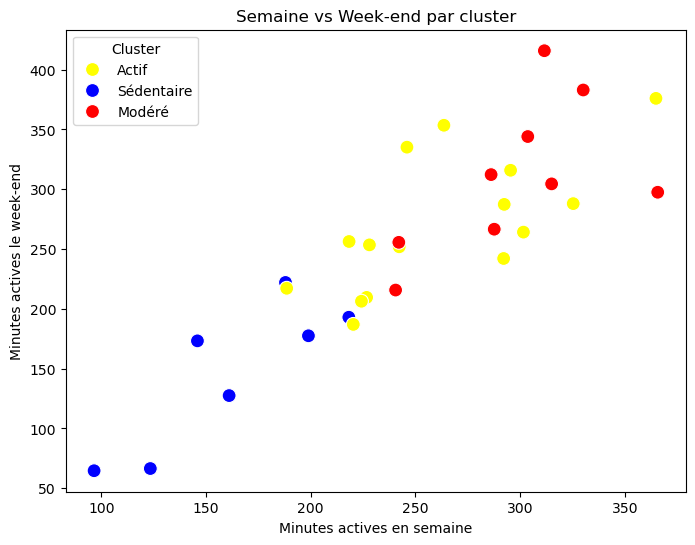

In [466]:
weekend_weekday_per_user = (
    df_clustered.groupby('Id').apply(
        lambda x: pd.Series({
            'mean_weekday_minutes': x.loc[~x['is_weekend'], 'TotalActiveMinutes'].mean(),
            'mean_weekend_minutes': x.loc[x['is_weekend'], 'TotalActiveMinutes'].mean(),
            'cluster_label': x['cluster_label'].iloc[0]
        })
    )
).reset_index()

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=weekend_weekday_per_user,
    x='mean_weekday_minutes',
    y='mean_weekend_minutes',
    hue='cluster_label',
    palette={'Sédentaire':'blue', 'Modéré':'red', 'Actif':'yellow'},
    s=100
)
plt.xlabel('Minutes actives en semaine')
plt.ylabel('Minutes actives le week-end')
plt.title('Semaine vs Week-end par cluster')
plt.legend(title='Cluster')
plt.show()

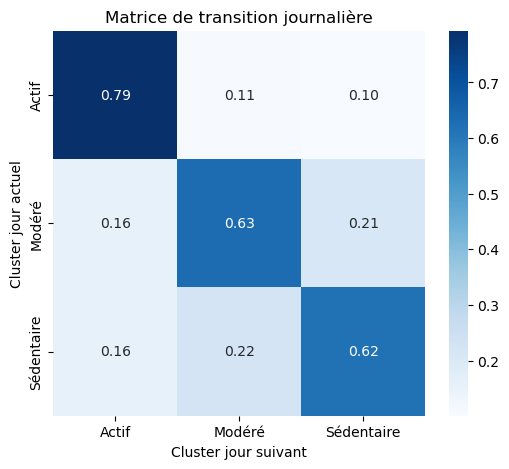

In [391]:
features_daily = ['TotalActiveMinutes', 'SedentaryMinutes']
df_daily_scaled = df_cluster.copy()

scaler = StandardScaler()
X_daily_scaled = scaler.fit_transform(df_daily_scaled[features_daily])

kmeans_daily = KMeans(n_clusters=3, random_state=42)
df_daily_scaled['cluster'] = kmeans_daily.fit_predict(X_daily_scaled)

df_daily_scaled = df_daily_scaled.sort_values(['Id', 'Date'])
df_daily_scaled['next_cluster'] = df_daily_scaled.groupby('Id')['cluster'].shift(-1)
transitions_daily = df_daily_scaled.dropna(subset=['next_cluster'])

order_daily = (
    df_daily_scaled
    .groupby('cluster')['TotalActiveMinutes']
    .mean()
    .sort_values()
    .index
)

mapping_daily = {old: new for new, old in enumerate(order_daily)}
df_daily_scaled['cluster_ordered'] = df_daily_scaled['cluster'].map(mapping_daily)

label_mapping = {0: 'Sédentaire', 1: 'Actif', 2: 'Modéré'}
df_daily_scaled['cluster_label'] = df_daily_scaled['cluster_ordered'].map(label_mapping)

transition_matrix_daily = pd.crosstab(
    transitions_daily['cluster'].map(mapping_daily).map(label_mapping),  
    transitions_daily['next_cluster'].map(mapping_daily).map(label_mapping), 
    normalize='index'
)

plt.figure(figsize=(6,5))
sns.heatmap(transition_matrix_daily, annot=True, cmap='Blues', fmt=".2f")
plt.xlabel("Cluster jour suivant")
plt.ylabel("Cluster jour actuel")
plt.title("Matrice de transition journalière")
plt.show()

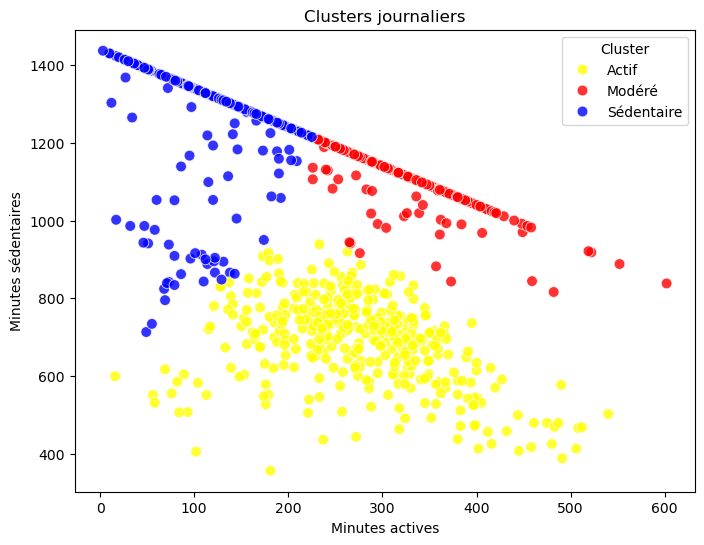

In [392]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    data=df_daily_scaled,
    x='TotalActiveMinutes',
    y='SedentaryMinutes',
    hue='cluster_label',
    palette={
        'Sédentaire': 'blue',
        'Modéré': 'red',
        'Actif': 'yellow'
    },
    s=60,
    alpha=0.8
)

plt.title("Clusters journaliers")
plt.xlabel("Minutes actives")
plt.ylabel("Minutes sédentaires")
plt.legend(title="Cluster")
plt.show()


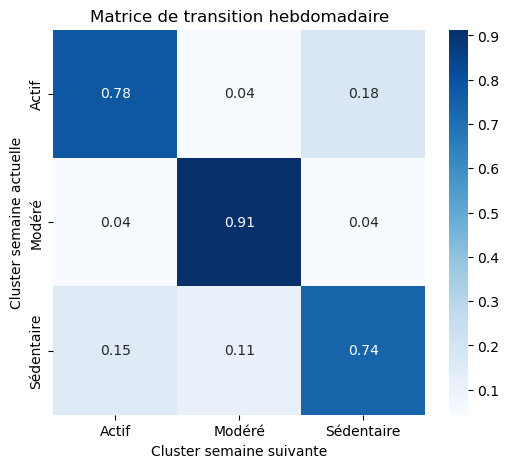

In [393]:
df_weekly = df_cluster.groupby(['Id','year','week']).agg(
    mean_total_active_minutes_week=('TotalActiveMinutes','mean'),
    mean_sedentary_minutes_week=('SedentaryMinutes','mean'),
    mean_total_steps_week=('TotalSteps','mean'),
    mean_calories_week=('Calories','mean')
).reset_index()

features_weekly = ['mean_total_active_minutes_week', 'mean_sedentary_minutes_week']
scaler = StandardScaler()
df_weekly_scaled = df_weekly.copy()
df_weekly_scaled[features_weekly] = scaler.fit_transform(df_weekly_scaled[features_weekly])

kmeans_weekly = KMeans(n_clusters=3, random_state=42)
df_weekly_scaled['cluster'] = kmeans_weekly.fit_predict(df_weekly_scaled[features_weekly])

df_weekly_scaled = df_weekly_scaled.sort_values(['Id','year','week'])
df_weekly_scaled['next_cluster'] = df_weekly_scaled.groupby('Id')['cluster'].shift(-1)
transitions_weekly = df_weekly_scaled.dropna(subset=['next_cluster'])

order_weekly = df_weekly_scaled.groupby('cluster')['mean_total_active_minutes_week'].mean().sort_values().index
mapping_weekly = {old: new for new, old in enumerate(order_weekly)}
df_weekly_scaled['cluster_ordered'] = df_weekly_scaled['cluster'].map(mapping_weekly)

label_mapping = {0: 'Sédentaire', 1: 'Modéré', 2: 'Actif'}
df_weekly_scaled['cluster_label'] = df_weekly_scaled['cluster_ordered'].map(label_mapping)

transition_matrix_weekly = pd.crosstab(
    transitions_weekly['cluster'].map(mapping_weekly).map(label_mapping),
    transitions_weekly['next_cluster'].map(mapping_weekly).map(label_mapping),
    normalize='index'
)

plt.figure(figsize=(6,5))
sns.heatmap(transition_matrix_weekly, annot=True, cmap='Blues', fmt=".2f")
plt.xlabel("Cluster semaine suivante")
plt.ylabel("Cluster semaine actuelle")
plt.title("Matrice de transition hebdomadaire")
plt.show()


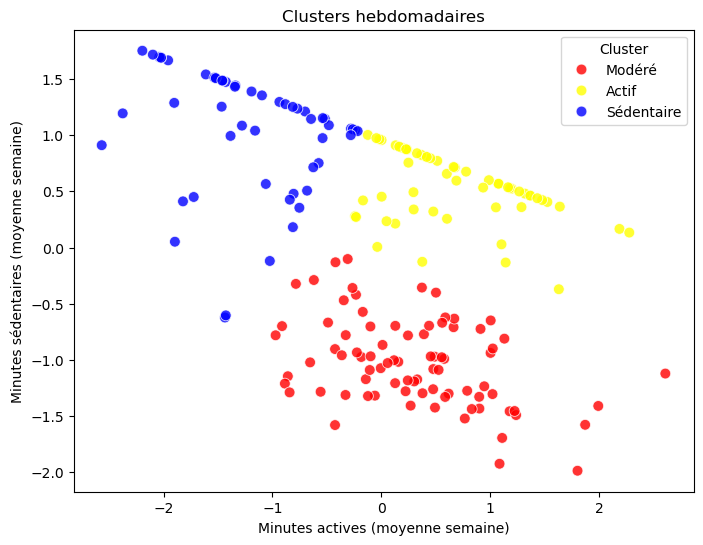

In [394]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    data=df_weekly_scaled,
    x='mean_total_active_minutes_week',
    y='mean_sedentary_minutes_week',
    hue='cluster_label',
    palette={
        'Sédentaire': 'blue',
        'Modéré': 'red',
        'Actif': 'yellow'
    },
    s=60,
    alpha=0.8
)

plt.title("Clusters hebdomadaires")
plt.xlabel("Minutes actives (moyenne semaine)")
plt.ylabel("Minutes sédentaires (moyenne semaine)")
plt.legend(title="Cluster")
plt.show()


*Différences sur d'autres variables pour chaque cluster*

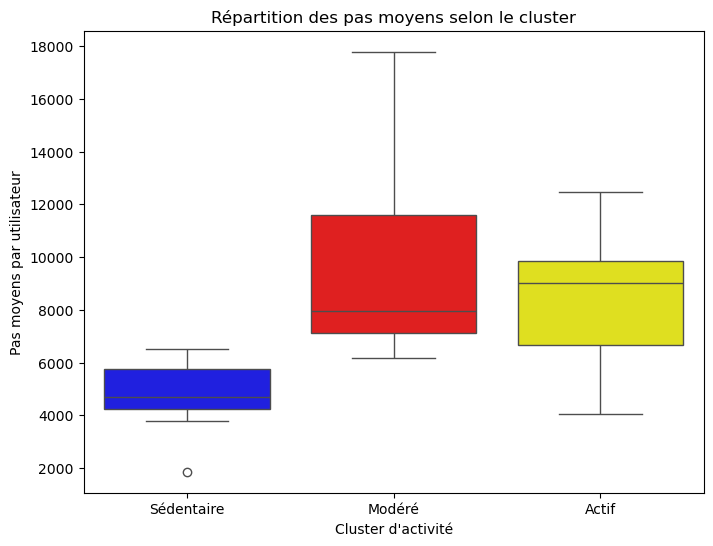

In [396]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x='cluster_label',
    y='mean_total_steps',
    hue='cluster_label',
    data=df_user_summary,
    palette={'Sédentaire':'blue', 'Modéré':'red', 'Actif':'yellow'},
    order=['Sédentaire','Modéré','Actif'],
    dodge=False
)
plt.xlabel("Cluster d'activité")
plt.ylabel("Pas moyens par utilisateur")
plt.title("Répartition des pas moyens selon le cluster")
plt.legend([],[], frameon=False)
plt.show()

In [397]:
for label in df_user_summary['cluster_label'].unique():
    stat, p = stats.shapiro(df_user_summary[df_user_summary['cluster_label'] == label]['mean_total_steps'])
    print(label, "p-value:", p)

stat, p = stats.levene(
    df_user_summary[df_user_summary['cluster_label'] == 'Sédentaire']['mean_total_steps'],
    df_user_summary[df_user_summary['cluster_label'] == 'Modéré']['mean_total_steps'],
    df_user_summary[df_user_summary['cluster_label'] == 'Actif']['mean_total_steps']
)
print("Levene p-value:", p)

# ANOVA
model = ols('mean_total_steps ~ C(cluster_label)', data=df_user_summary).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("Tableau ANOVA :\n", anova_table)

# Post-hoc
tukey = pairwise_tukeyhsd(endog=df_user_summary['mean_total_steps'],
                          groups=df_user_summary['cluster_label'],
                          alpha=0.05)
print("\nRésultats post-hoc de Tukey :")
print(tukey)

print("\nMoyennes par cluster :")
print(df_user_summary.groupby('cluster_label')['mean_total_steps'].mean())

Actif p-value: 0.4810987836350922
Sédentaire p-value: 0.5387898398060703
Modéré p-value: 0.1376806661674082
Levene p-value: 0.21637803906045686
Tableau ANOVA :
                         sum_sq    df         F   PR(>F)
C(cluster_label)  1.205927e+08   2.0  7.484123  0.00249
Residual          2.255839e+08  28.0       NaN      NaN

Résultats post-hoc de Tukey :
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1   group2    meandiff  p-adj    lower      upper    reject
----------------------------------------------------------------
 Actif     Modéré  1879.0374  0.275 -1082.2116  4840.2864  False
 Actif Sédentaire -3606.6785 0.0255 -6821.4706  -391.8865   True
Modéré Sédentaire -5485.7159 0.0018 -9025.0855 -1946.3464   True
----------------------------------------------------------------

Moyennes par cluster :
cluster_label
Actif          8328.918652
Modéré        10207.956052
Sédentaire     4722.240111
Name: mean_total_steps, dtype: float64


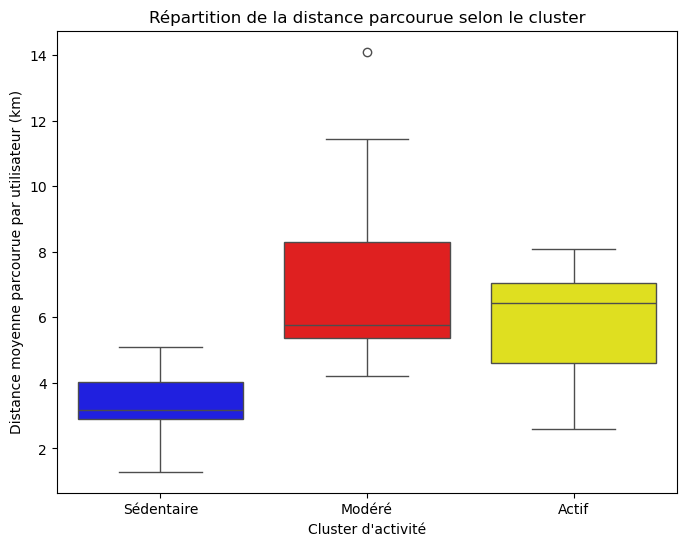

In [398]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x='cluster_label',
    y='mean_total_distance_km',
    hue='cluster_label',
    data=df_user_summary,
    palette={'Sédentaire':'blue', 'Modéré':'red', 'Actif':'yellow'},
    order=['Sédentaire','Modéré','Actif'],
    dodge=False
)
plt.xlabel("Cluster d'activité")
plt.ylabel("Distance moyenne parcourue par utilisateur (km)")
plt.title("Répartition de la distance parcourue selon le cluster")
plt.legend([],[], frameon=False)
plt.show()

In [399]:
for label in df_user_summary['cluster_label'].unique():
    stat, p = stats.shapiro(df_user_summary[df_user_summary['cluster_label'] == label]['mean_total_distance_km'])
    print(label, "p-value:", p)

stat, p = stats.levene(
    df_user_summary[df_user_summary['cluster_label'] == 'Sédentaire']['mean_total_distance_km'],
    df_user_summary[df_user_summary['cluster_label'] == 'Modéré']['mean_total_distance_km'],
    df_user_summary[df_user_summary['cluster_label'] == 'Actif']['mean_total_distance_km']
)
print("Levene p-value:", p)

model = ols('mean_total_distance_km ~ C(cluster_label)', data=df_user_summary).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("Tableau ANOVA :\n", anova_table)

tukey = pairwise_tukeyhsd(endog=df_user_summary['mean_total_distance_km'],
                          groups=df_user_summary['cluster_label'],
                          alpha=0.05)
print("\nRésultats post-hoc de Tukey :")
print(tukey)

print("\nMoyennes par cluster :")
print(df_user_summary.groupby('cluster_label')['mean_total_distance_km'].mean())

Actif p-value: 0.05390915757710578
Sédentaire p-value: 0.8393667742617312
Modéré p-value: 0.10141614368145757
Levene p-value: 0.1719014003931642
Tableau ANOVA :
                       sum_sq    df         F    PR(>F)
C(cluster_label)   67.848322   2.0  6.666822  0.004285
Residual          142.478150  28.0       NaN       NaN

Résultats post-hoc de Tukey :
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1   group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------
 Actif     Modéré   1.6772 0.2003 -0.6762  4.0306  False
 Actif Sédentaire  -2.4694 0.0597 -5.0243  0.0855  False
Modéré Sédentaire  -4.1466  0.003 -6.9595 -1.3338   True
--------------------------------------------------------

Moyennes par cluster :
cluster_label
Actif         5.811521
Modéré        7.488753
Sédentaire    3.342133
Name: mean_total_distance_km, dtype: float64


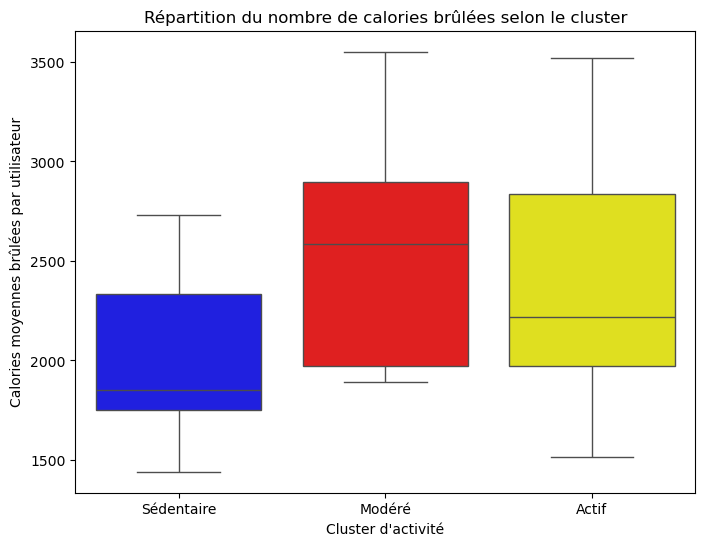

In [400]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x='cluster_label',
    y='mean_calories',
    hue='cluster_label',
    data=df_user_summary,
    palette={'Sédentaire':'blue', 'Modéré':'red', 'Actif':'yellow'},
    order=['Sédentaire','Modéré','Actif'],
    dodge=False
)
plt.xlabel("Cluster d'activité")
plt.ylabel("Calories moyennes brûlées par utilisateur")
plt.title("Répartition du nombre de calories brûlées selon le cluster")
plt.legend([],[], frameon=False)
plt.show()

In [401]:
for label in df_user_summary['cluster_label'].unique():
    stat, p = stats.shapiro(df_user_summary[df_user_summary['cluster_label'] == label]['mean_calories'])
    print(label, "p-value:", p)

stat, p = stats.levene(
    df_user_summary[df_user_summary['cluster_label'] == 'Sédentaire']['mean_calories'],
    df_user_summary[df_user_summary['cluster_label'] == 'Modéré']['mean_calories'],
    df_user_summary[df_user_summary['cluster_label'] == 'Actif']['mean_calories']
)
print("Levene p-value:", p)

model = ols('mean_calories ~ C(cluster_label)', data=df_user_summary).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("Tableau ANOVA :\n", anova_table)

tukey = pairwise_tukeyhsd(endog=df_user_summary['mean_calories'],
                          groups=df_user_summary['cluster_label'],
                          alpha=0.05)
print("\nRésultats post-hoc de Tukey :")
print(tukey)

print("\nMoyennes par cluster :")
print(df_user_summary.groupby('cluster_label')['mean_calories'].mean())

Actif p-value: 0.286682166653696
Sédentaire p-value: 0.6918454259196228
Modéré p-value: 0.3885689547475439
Levene p-value: 0.6885007501777685
Tableau ANOVA :
                         sum_sq    df         F    PR(>F)
C(cluster_label)  1.182483e+06   2.0  1.746308  0.192881
Residual          9.479862e+06  28.0       NaN       NaN

Résultats post-hoc de Tukey :
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1   group2    meandiff p-adj    lower     upper   reject
-------------------------------------------------------------
 Actif     Modéré  165.0793  0.781  -441.9671 772.1257  False
 Actif Sédentaire  -373.883 0.3527  -1032.905 285.1389  False
Modéré Sédentaire -538.9623 0.1759 -1264.5216 186.5969  False
-------------------------------------------------------------

Moyennes par cluster :
cluster_label
Actif         2401.390823
Modéré        2566.470102
Sédentaire    2027.507780
Name: mean_calories, dtype: float64


*Comparison of sleep data for each cluster*

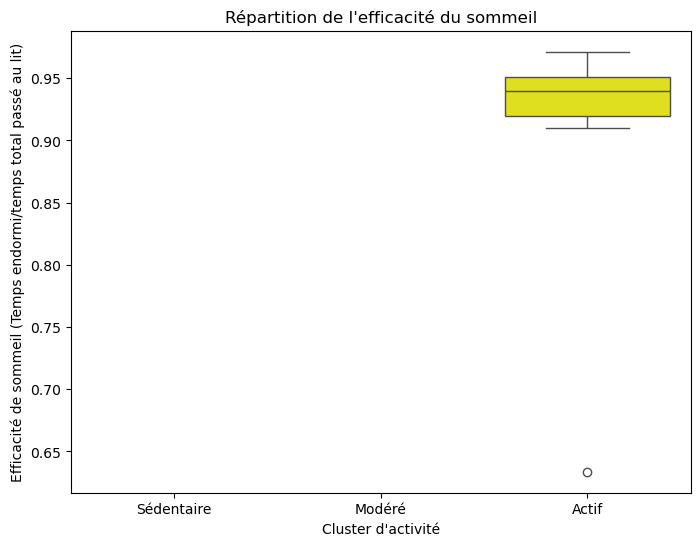

In [472]:
df_sleep_avg = df_sleep_data_cleaned.groupby('Id')['SleepEfficiency'].mean().reset_index(name='mean_sleep_efficiency')
common_ids = set(df_user_summary['Id']).intersection(set(df_sleep_avg['Id']))
df_clusters_sleep = df_user_summary[df_user_summary['Id'].isin(common_ids)][['Id','cluster_label']]
df_plot = df_sleep_avg[df_sleep_avg['Id'].isin(common_ids)].merge(df_clusters_sleep, on='Id', how='left')

plt.figure(figsize=(8,6))
sns.boxplot(
    x='cluster_label',
    y='mean_sleep_efficiency',
    data=df_plot,
    palette={'Sédentaire':'blue', 'Modéré':'red', 'Actif':'yellow'},
    order=['Sédentaire','Modéré','Actif']
)
plt.xlabel("Cluster d'activité")
plt.ylabel("Efficacité de sommeil (Temps endormi/temps total passé au lit)")
plt.title("Répartition de l'efficacité du sommeil")
plt.show()


In [404]:
df_plot['cluster_label'].value_counts()

cluster_label
Actif    14
Name: count, dtype: int64

*Comparison of BMI for each cluster*

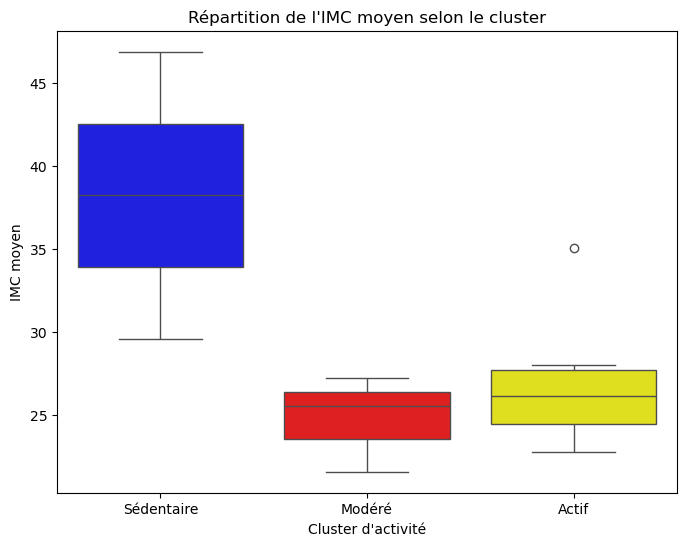

In [406]:
df_bmi_avg = df_weight_data_cleaned.groupby('Id')['BMI'].mean().reset_index(name='mean_BMI')
common_ids = set(df_user_summary['Id']).intersection(set(df_bmi_avg['Id']))
df_clusters_weight = df_user_summary[df_user_summary['Id'].isin(common_ids)][['Id','cluster_label']]
df_plot = df_bmi_avg[df_bmi_avg['Id'].isin(common_ids)].merge(df_clusters_weight, on='Id', how='left')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

all_clusters = ['Sédentaire','Modéré','Actif']
df_plot['cluster_label'] = pd.Categorical(df_plot['cluster_label'], categories=all_clusters, ordered=True)

plt.figure(figsize=(8,6))
sns.boxplot(
    x='cluster_label',
    y='mean_BMI',
    data=df_plot,
    palette={'Sédentaire':'blue', 'Modéré':'red', 'Actif':'yellow'},
    order=all_clusters
)
plt.xlabel("Cluster d'activité")
plt.ylabel("IMC moyen")
plt.title("Répartition de l'IMC moyen selon le cluster")
plt.show()
